<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/Training_optic_Discs_in_Densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinopathy Detection

Kaggle has a large competition of Diabetic Retinopathy detection which can be found here:
https://www.kaggle.com/c/diabetic-retinopathy-detection/

Their dataset consists in 35126 images labeled from 0 to 4 according to the degree of Retinopathy.
An analysis of the data is provided in this notebook.

In [1]:
!rm -rf sample_data
!nvidia-smi

Tue Apr 27 02:47:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install dependencies

In [2]:
from IPython.display import clear_output

#!pip install torch==1.7.1+cu101 torchvision==0.8.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install efficientnet_pytorch
clear_output(wait=False)

## Load data from local drive


In [4]:
## ORIGINAL DATA

!wget -O File.zip "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/ETdcB8GscyBAkhUFvNMzpoUBLLgg7ej9Q3t4rK_bR8ngSA?download=1"
!unzip File.zip
!rm File.zip
clear_output(wait=False)
print("Data Downloaded")

Data Downloaded


In [5]:
!wget -O File.zip "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/Ea5EziAZKiVGgvYIqubZk04BSQOx4B1IMXLqQu8Fc5nKOA?download=1"
!unzip File.zip
!rm File.zip
clear_output(wait = False)

In [6]:
!rm checkpoint*

rm: cannot remove 'checkpoint*': No such file or directory


In [7]:
import pandas as pd
import os

Bad =  pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/LVL4_OD",File) for File in os.listdir("./OpticDiscs/LVL4_OD") if ".jpeg" in File]})
Good = pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/LVL0_OD",File) for File in os.listdir("./OpticDiscs/LVL0_OD") if ".jpeg" in File]}).sample(len(Bad),random_state = 42)

data = pd.concat((Good,Bad),axis = 0)
data.head()
data['class'] = data['imageFilename'].apply(lambda x : 1 if "LVL0" in x else 0)
data = data.reset_index()
data = data[['imageFilename','class']]
data.head()

,imageFilename,class
0,./OpticDiscs/LVL0_OD/263_p_41307_right.jpeg,1
1,./OpticDiscs/LVL0_OD/258_p_40410_right.jpeg,1
2,./OpticDiscs/LVL0_OD/186_p_29423_right.jpeg,1
3,./OpticDiscs/LVL0_OD/182_p_28949_right.jpeg,1
4,./OpticDiscs/LVL0_OD/8_p_1772_left.jpeg,1


In [8]:
len(data)

396

#### Split data

In [9]:
from sklearn.model_selection import train_test_split

Train,Validation = train_test_split(data,test_size = 0.40,random_state = 65)
X_train = Train['imageFilename']
y_train = Train['class']
#Split data
X_validation, X_test, y_validation, y_test = train_test_split(Validation['imageFilename'], Validation['class'], test_size=0.50, random_state=65)


In [10]:
print("Datos de entrenamiento:")
print(y_train.value_counts())
print("Datos de validación:")
print(y_validation.value_counts())
print("Datos de test:")
print(y_test.value_counts())

Datos de entrenamiento:
0    122
1    115
Name: class, dtype: int64
Datos de validación:
0    40
1    39
Name: class, dtype: int64
Datos de test:
1    44
0    36
Name: class, dtype: int64


In [11]:
test_data = pd.DataFrame({'image':X_test,'class':y_test})
test_data['image'] = test_data['image'].apply(lambda x : x.split('/')[-1])
test_data.head()

,image,class
43,151_p_23982_right.jpeg,1
156,69_p_11365_left.jpeg,1
56,266_p_41580_left.jpeg,1
67,279_p_43467_left.jpeg,1
190,233_p_36533_left.jpeg,1


In [12]:
test_data.to_csv('test_data.csv',index=False)

## Definition of the model

In [13]:
import torchvision.models as models
import torch
network_name = 'densenet161'
model = models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


In [14]:
model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [15]:
## Change efficientnet final layer
model.classifier = torch.nn.Linear(in_features=2208,out_features=2,bias = True)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

26476418

In [17]:
from torchvision.transforms import Resize,ToTensor,Compose,Normalize
from torchvision.transforms import RandomHorizontalFlip,RandomVerticalFlip,RandomRotation,ColorJitter,RandomResizedCrop,RandomPerspective,GaussianBlur
from PIL import Image

transforms = Compose([RandomHorizontalFlip(),RandomVerticalFlip(),
                      RandomRotation(180),ColorJitter(0.5,0.5,0.5),
                      RandomResizedCrop((224 ,224), scale=(0.7, 1.2)),
                      RandomPerspective(),
                      GaussianBlur((3,3))]) # Transformations for the training images

composed = Compose([Resize(224), # Resize to a fit size for efficientnet
                    ToTensor(),  # Convert into sensor
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize image

### Training parameters

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);
seed = 17
torch.manual_seed(seed)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

In [19]:
try:
    model = torch.load('./checkpoint_densenet161_87_0.93333.ph', map_location=device)
except:
    print("No Checkpoint loaded")

No Checkpoint loaded


In [20]:
classes = {0:[0,0,0,0,1],
           1:[0,0,0,1,0],
           2:[0,0,1,0,0],
           3:[0,1,0,0,0],
           4:[1,0,0,0,0]}

In [21]:
from tqdm import tqdm
import random
random.seed(seed)

epochs = 100
batch_size = 1  # I will use batch size of 1 to keep the ratio of each image

TRAINING_acc = []
VALIDATION_acc = []
BEST_val_acc = 0.0

for epoch in range(epochs):
    
    indexes = [idx for idx in range(len(X_train))]
    pbar = tqdm( range(len(X_train)//batch_size),ncols = 100)
    running_loss = 0.0
    running_acc = 0.0
    t = 0

    for step in pbar:
        # Load data
        idx = random.sample(indexes,batch_size)
        X = X_train.iloc[idx]
        y = y_train.iloc[idx]

        # Remove indexes
        [indexes.remove(i) for i in idx]

        # Load images
        try:
            images = [Image.open(File) for File in X]
        except:
            continue
        # Load y_true
        y_true = torch.LongTensor([c for c in y]).to(device)
        
        # Convert images to tensor
        x_batch = torch.FloatTensor().to(device)
        for image in images:
            P = transforms(image)
            P = composed(P).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(x_batch)
        loss = criterion(outputs, y_true)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        t += batch_size

        _, preds = torch.max(outputs, 1)
        running_acc += torch.sum(preds == y_true).cpu().detach().numpy()
        acc = torch.sum(preds == y_true).cpu().detach().numpy()/batch_size;
        pbar.set_description("Epoch: {} Accuracy: {:0.5f} Loss: {:0.5f} ".format(epoch+1,running_acc/t,loss.item()))
    #Validation
    TRAINING_acc.append(running_acc/t)
    val_acc = 0.0
    val_loss = 0.0
    t = 0
    for point in range(len(X_validation)//batch_size):
        with torch.no_grad():

            X = X_validation.iloc[point*batch_size:(point+1)*batch_size]
            y = y_validation.iloc[point*batch_size:(point+1)*batch_size]


            # Load images
            try:
                images = [Image.open(File) for File in X]
            except:
                continue
            # Load y_true
            y_true = torch.LongTensor([c for c in y]).to(device)
            
            # Convert images to tensor
            x_batch = torch.FloatTensor().to(device)
            for image in images:
                P = composed(image).unsqueeze(0).to(device)
                x_batch = torch.cat((x_batch,P))

            
            outputs = model(x_batch)
            loss = criterion(outputs, y_true)
            val_loss += loss.item()
            t += batch_size
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == y_true).cpu().detach().numpy()
    VALIDATION_acc.append(val_acc/t)
    print("Validation -- Accuracy: {:0.5f} Loss: {:0.5f} \n".format(val_acc/t,loss.item()))
    if val_acc/t > BEST_val_acc:
        try:
            torch.save(model,"/content/checkpoint_{}_{}_{:0.5f}.ph".format(network_name,epoch+1,val_acc/t))
            BEST_val_acc = val_acc/t
        except:
            continue

Epoch: 1 Accuracy: 0.51477 Loss: 0.78669 : 100%|██████████████████| 237/237 [00:36<00:00,  6.56it/s]


Validation -- Accuracy: 0.50633 Loss: 0.72086 



Epoch: 3 Accuracy: 1.00000 Loss: 0.66840 :   0%|                    | 1/237 [00:00<00:28,  8.15it/s]

Validation -- Accuracy: 0.50633 Loss: 0.59783 



Epoch: 3 Accuracy: 0.58228 Loss: 0.49688 : 100%|██████████████████| 237/237 [00:35<00:00,  6.74it/s]


Validation -- Accuracy: 0.62025 Loss: 0.54636 



Epoch: 4 Accuracy: 0.70042 Loss: 1.34535 : 100%|██████████████████| 237/237 [00:35<00:00,  6.68it/s]


Validation -- Accuracy: 0.74684 Loss: 0.36807 



Epoch: 6 Accuracy: 0.00000 Loss: 1.17692 :   0%|                    | 1/237 [00:00<00:33,  7.10it/s]

Validation -- Accuracy: 0.70886 Loss: 0.61084 



Epoch: 7 Accuracy: 1.00000 Loss: 0.16925 :   0%|                    | 1/237 [00:00<00:38,  6.09it/s]

Validation -- Accuracy: 0.73418 Loss: 0.87362 



Epoch: 8 Accuracy: 1.00000 Loss: 0.31720 :   0%|                    | 1/237 [00:00<00:32,  7.21it/s]

Validation -- Accuracy: 0.65823 Loss: 1.33575 



Epoch: 9 Accuracy: 0.00000 Loss: 1.29874 :   0%|                    | 1/237 [00:00<00:30,  7.82it/s]

Validation -- Accuracy: 0.55696 Loss: 0.12342 



Epoch: 9 Accuracy: 0.81435 Loss: 0.43519 : 100%|██████████████████| 237/237 [00:35<00:00,  6.74it/s]


Validation -- Accuracy: 0.79747 Loss: 0.18069 



Epoch: 11 Accuracy: 0.00000 Loss: 0.81531 :   0%|                   | 1/237 [00:00<00:32,  7.27it/s]

Validation -- Accuracy: 0.79747 Loss: 0.21052 



Epoch: 12 Accuracy: 0.00000 Loss: 0.95608 :   0%|                   | 1/237 [00:00<00:39,  5.90it/s]

Validation -- Accuracy: 0.62025 Loss: 0.14806 



Epoch: 13 Accuracy: 1.00000 Loss: 0.12467 :   0%|                   | 1/237 [00:00<00:28,  8.36it/s]

Validation -- Accuracy: 0.75949 Loss: 0.26230 



Epoch: 14 Accuracy: 1.00000 Loss: 0.16466 :   0%|                   | 1/237 [00:00<00:31,  7.38it/s]

Validation -- Accuracy: 0.75949 Loss: 0.45449 



Epoch: 15 Accuracy: 1.00000 Loss: 0.67022 :   0%|                   | 1/237 [00:00<00:29,  7.90it/s]

Validation -- Accuracy: 0.73418 Loss: 0.10766 



Epoch: 16 Accuracy: 1.00000 Loss: 0.07234 :   0%|                   | 1/237 [00:00<00:27,  8.50it/s]

Validation -- Accuracy: 0.69620 Loss: 0.18181 



Epoch: 17 Accuracy: 0.00000 Loss: 1.55097 :   0%|                   | 1/237 [00:00<00:32,  7.30it/s]

Validation -- Accuracy: 0.79747 Loss: 0.11291 



Epoch: 18 Accuracy: 1.00000 Loss: 0.31844 :   0%|                   | 1/237 [00:00<00:32,  7.26it/s]

Validation -- Accuracy: 0.70886 Loss: 0.06235 



Epoch: 18 Accuracy: 0.83966 Loss: 0.15772 : 100%|█████████████████| 237/237 [00:35<00:00,  6.67it/s]


Validation -- Accuracy: 0.82278 Loss: 0.19365 



Epoch: 20 Accuracy: 1.00000 Loss: 0.06893 :   0%|                   | 1/237 [00:00<00:35,  6.60it/s]

Validation -- Accuracy: 0.79747 Loss: 0.09693 



Epoch: 21 Accuracy: 1.00000 Loss: 0.05601 :   0%|                   | 1/237 [00:00<00:33,  7.13it/s]

Validation -- Accuracy: 0.79747 Loss: 0.16334 



Epoch: 22 Accuracy: 1.00000 Loss: 0.05765 :   0%|                   | 1/237 [00:00<00:32,  7.37it/s]

Validation -- Accuracy: 0.74684 Loss: 0.06042 



  0%|                                                                       | 0/237 [00:00<?, ?it/s]

Validation -- Accuracy: 0.77215 Loss: 0.04750 



Epoch: 24 Accuracy: 0.00000 Loss: 2.94026 :   0%|                   | 1/237 [00:00<00:33,  7.09it/s]

Validation -- Accuracy: 0.65823 Loss: 0.04696 



Epoch: 24 Accuracy: 0.89451 Loss: 0.04540 : 100%|█████████████████| 237/237 [00:36<00:00,  6.44it/s]


Validation -- Accuracy: 0.87342 Loss: 0.10585 



Epoch: 26 Accuracy: 1.00000 Loss: 0.04600 :   0%|                   | 1/237 [00:00<00:32,  7.17it/s]

Validation -- Accuracy: 0.79747 Loss: 0.07260 



Epoch: 27 Accuracy: 1.00000 Loss: 0.09176 :   0%|                   | 1/237 [00:00<00:40,  5.88it/s]

Validation -- Accuracy: 0.77215 Loss: 0.08989 



Epoch: 28 Accuracy: 1.00000 Loss: 0.30534 :   0%|                   | 1/237 [00:00<00:39,  6.01it/s]

Validation -- Accuracy: 0.68354 Loss: 0.03855 



Epoch: 29 Accuracy: 1.00000 Loss: 0.36042 :   0%|                   | 1/237 [00:00<00:33,  7.08it/s]

Validation -- Accuracy: 0.83544 Loss: 0.06615 



Epoch: 30 Accuracy: 1.00000 Loss: 0.03928 :   0%|                   | 1/237 [00:00<00:34,  6.77it/s]

Validation -- Accuracy: 0.87342 Loss: 0.19888 



Epoch: 31 Accuracy: 1.00000 Loss: 0.03370 :   0%|                   | 1/237 [00:00<00:29,  8.02it/s]

Validation -- Accuracy: 0.83544 Loss: 0.96745 



Epoch: 32 Accuracy: 1.00000 Loss: 0.05758 :   0%|                   | 1/237 [00:00<00:33,  7.14it/s]

Validation -- Accuracy: 0.78481 Loss: 0.38842 



Epoch: 33 Accuracy: 1.00000 Loss: 0.03860 :   0%|                   | 1/237 [00:00<00:34,  6.83it/s]

Validation -- Accuracy: 0.84810 Loss: 0.45491 



Epoch: 34 Accuracy: 1.00000 Loss: 0.03419 :   0%|                   | 1/237 [00:00<00:32,  7.27it/s]

Validation -- Accuracy: 0.84810 Loss: 0.17862 



Epoch: 35 Accuracy: 1.00000 Loss: 0.14790 :   0%|                   | 1/237 [00:00<00:34,  6.88it/s]

Validation -- Accuracy: 0.70886 Loss: 0.03703 



Epoch: 36 Accuracy: 1.00000 Loss: 0.03225 :   0%|                   | 1/237 [00:00<00:32,  7.35it/s]

Validation -- Accuracy: 0.75949 Loss: 0.04672 



Epoch: 37 Accuracy: 1.00000 Loss: 0.03389 :   0%|                   | 1/237 [00:00<00:31,  7.52it/s]

Validation -- Accuracy: 0.74684 Loss: 0.03264 



Epoch: 38 Accuracy: 1.00000 Loss: 0.12662 :   0%|                   | 1/237 [00:00<00:30,  7.67it/s]

Validation -- Accuracy: 0.84810 Loss: 0.01967 



Epoch: 39 Accuracy: 1.00000 Loss: 0.06868 :   0%|                   | 1/237 [00:00<00:39,  6.00it/s]

Validation -- Accuracy: 0.74684 Loss: 0.02167 



Epoch: 40 Accuracy: 1.00000 Loss: 0.02007 :   0%|                   | 1/237 [00:00<00:42,  5.49it/s]

Validation -- Accuracy: 0.79747 Loss: 0.02367 



Epoch: 41 Accuracy: 1.00000 Loss: 0.16404 :   0%|                   | 1/237 [00:00<00:32,  7.25it/s]

Validation -- Accuracy: 0.77215 Loss: 0.06147 



Epoch: 42 Accuracy: 1.00000 Loss: 0.02043 :   0%|                   | 1/237 [00:00<00:32,  7.16it/s]

Validation -- Accuracy: 0.72152 Loss: 0.01792 



Epoch: 42 Accuracy: 0.93249 Loss: 0.03328 : 100%|█████████████████| 237/237 [00:36<00:00,  6.55it/s]


Validation -- Accuracy: 0.88608 Loss: 0.05734 



Epoch: 44 Accuracy: 1.00000 Loss: 0.02594 :   0%|                   | 1/237 [00:00<00:36,  6.52it/s]

Validation -- Accuracy: 0.81013 Loss: 0.02483 



Epoch: 45 Accuracy: 1.00000 Loss: 0.04548 :   0%|                   | 1/237 [00:00<00:30,  7.69it/s]

Validation -- Accuracy: 0.78481 Loss: 0.01363 



Epoch: 46 Accuracy: 1.00000 Loss: 0.03370 :   0%|                   | 1/237 [00:00<00:33,  6.98it/s]

Validation -- Accuracy: 0.75949 Loss: 0.01148 



Epoch: 47 Accuracy: 1.00000 Loss: 0.08240 :   0%|                   | 1/237 [00:00<00:30,  7.67it/s]

Validation -- Accuracy: 0.75949 Loss: 0.03353 



Epoch: 48 Accuracy: 1.00000 Loss: 0.03412 :   0%|                   | 1/237 [00:00<00:29,  8.12it/s]

Validation -- Accuracy: 0.83544 Loss: 0.01380 



Epoch: 49 Accuracy: 1.00000 Loss: 0.11895 :   0%|                   | 1/237 [00:00<00:30,  7.64it/s]

Validation -- Accuracy: 0.70886 Loss: 0.10254 



Epoch: 50 Accuracy: 1.00000 Loss: 0.03380 :   0%|                   | 1/237 [00:00<00:32,  7.22it/s]

Validation -- Accuracy: 0.77215 Loss: 0.00843 



Epoch: 51 Accuracy: 1.00000 Loss: 0.03854 :   0%|                   | 1/237 [00:00<00:34,  6.77it/s]

Validation -- Accuracy: 0.74684 Loss: 0.02336 



Epoch: 52 Accuracy: 1.00000 Loss: 0.02147 :   0%|                   | 1/237 [00:00<00:32,  7.27it/s]

Validation -- Accuracy: 0.88608 Loss: 0.02024 



Epoch: 53 Accuracy: 1.00000 Loss: 0.03430 :   0%|                   | 1/237 [00:00<00:34,  6.92it/s]

Validation -- Accuracy: 0.74684 Loss: 0.00936 



Epoch: 54 Accuracy: 0.00000 Loss: 1.79124 :   0%|                   | 1/237 [00:00<00:27,  8.66it/s]

Validation -- Accuracy: 0.78481 Loss: 0.01026 



Epoch: 55 Accuracy: 0.00000 Loss: 0.78734 :   0%|                   | 1/237 [00:00<00:28,  8.22it/s]

Validation -- Accuracy: 0.58228 Loss: 0.00601 



Epoch: 56 Accuracy: 1.00000 Loss: 0.01162 :   0%|                   | 1/237 [00:00<00:35,  6.64it/s]

Validation -- Accuracy: 0.83544 Loss: 0.01027 



Epoch: 57 Accuracy: 1.00000 Loss: 0.08839 :   0%|                   | 1/237 [00:00<00:29,  7.95it/s]

Validation -- Accuracy: 0.82278 Loss: 0.00692 



Epoch: 58 Accuracy: 1.00000 Loss: 0.02660 :   0%|                   | 1/237 [00:00<00:30,  7.73it/s]

Validation -- Accuracy: 0.84810 Loss: 0.01169 



Epoch: 59 Accuracy: 1.00000 Loss: 0.19923 :   0%|                   | 1/237 [00:00<00:31,  7.54it/s]

Validation -- Accuracy: 0.82278 Loss: 0.01351 



Epoch: 60 Accuracy: 0.00000 Loss: 0.81591 :   0%|                   | 1/237 [00:00<00:39,  5.95it/s]

Validation -- Accuracy: 0.86076 Loss: 0.00835 



Epoch: 61 Accuracy: 1.00000 Loss: 0.00975 :   0%|                   | 1/237 [00:00<00:33,  7.05it/s]

Validation -- Accuracy: 0.87342 Loss: 0.01413 



Epoch: 62 Accuracy: 1.00000 Loss: 0.02536 :   0%|                   | 1/237 [00:00<00:30,  7.85it/s]

Validation -- Accuracy: 0.84810 Loss: 0.00927 



Epoch: 63 Accuracy: 1.00000 Loss: 0.00945 :   0%|                   | 1/237 [00:00<00:34,  6.87it/s]

Validation -- Accuracy: 0.81013 Loss: 0.03253 



Epoch: 64 Accuracy: 1.00000 Loss: 0.00492 :   0%|                   | 1/237 [00:00<00:30,  7.62it/s]

Validation -- Accuracy: 0.78481 Loss: 0.00633 



Epoch: 65 Accuracy: 0.00000 Loss: 2.44846 :   0%|                   | 1/237 [00:00<00:34,  6.82it/s]

Validation -- Accuracy: 0.82278 Loss: 0.01715 



Epoch: 66 Accuracy: 1.00000 Loss: 0.01809 :   0%|                   | 1/237 [00:00<00:32,  7.32it/s]

Validation -- Accuracy: 0.79747 Loss: 0.05969 



Epoch: 67 Accuracy: 1.00000 Loss: 0.00600 :   0%|                   | 1/237 [00:00<00:32,  7.21it/s]

Validation -- Accuracy: 0.87342 Loss: 0.00989 



Epoch: 68 Accuracy: 1.00000 Loss: 0.00510 :   0%|                   | 1/237 [00:00<00:37,  6.23it/s]

Validation -- Accuracy: 0.81013 Loss: 0.00747 



Epoch: 69 Accuracy: 1.00000 Loss: 0.02747 :   0%|                   | 1/237 [00:00<00:30,  7.65it/s]

Validation -- Accuracy: 0.83544 Loss: 0.02091 



  0%|                                                                       | 0/237 [00:00<?, ?it/s]

Validation -- Accuracy: 0.70886 Loss: 0.00891 



Epoch: 71 Accuracy: 1.00000 Loss: 0.62443 :   0%|                   | 1/237 [00:00<00:30,  7.85it/s]

Validation -- Accuracy: 0.81013 Loss: 0.00931 



Epoch: 72 Accuracy: 1.00000 Loss: 0.24437 :   0%|                   | 1/237 [00:00<00:31,  7.39it/s]

Validation -- Accuracy: 0.83544 Loss: 0.01254 



Epoch: 73 Accuracy: 1.00000 Loss: 0.00655 :   0%|                   | 1/237 [00:00<00:35,  6.63it/s]

Validation -- Accuracy: 0.86076 Loss: 0.01602 



Epoch: 74 Accuracy: 1.00000 Loss: 0.12363 :   0%|                   | 1/237 [00:00<00:36,  6.40it/s]

Validation -- Accuracy: 0.81013 Loss: 0.04593 



Epoch: 75 Accuracy: 1.00000 Loss: 0.00946 :   0%|                   | 1/237 [00:00<00:33,  7.13it/s]

Validation -- Accuracy: 0.88608 Loss: 0.00757 



Epoch: 76 Accuracy: 1.00000 Loss: 0.01258 :   0%|                   | 1/237 [00:00<00:27,  8.57it/s]

Validation -- Accuracy: 0.84810 Loss: 0.00653 



Epoch: 77 Accuracy: 1.00000 Loss: 0.01229 :   0%|                   | 1/237 [00:00<00:30,  7.70it/s]

Validation -- Accuracy: 0.79747 Loss: 0.00580 



Epoch: 78 Accuracy: 1.00000 Loss: 0.01000 :   0%|                   | 1/237 [00:00<00:35,  6.71it/s]

Validation -- Accuracy: 0.87342 Loss: 0.00678 



Epoch: 79 Accuracy: 1.00000 Loss: 0.00730 :   0%|                   | 1/237 [00:00<00:36,  6.54it/s]

Validation -- Accuracy: 0.86076 Loss: 0.01090 



Epoch: 80 Accuracy: 1.00000 Loss: 0.00719 :   0%|                   | 1/237 [00:00<00:32,  7.29it/s]

Validation -- Accuracy: 0.75949 Loss: 0.00585 



Epoch: 81 Accuracy: 1.00000 Loss: 0.02274 :   0%|                   | 1/237 [00:00<00:30,  7.65it/s]

Validation -- Accuracy: 0.83544 Loss: 0.00755 



Epoch: 82 Accuracy: 1.00000 Loss: 0.01730 :   0%|                   | 1/237 [00:00<00:32,  7.30it/s]

Validation -- Accuracy: 0.84810 Loss: 0.00692 



Epoch: 83 Accuracy: 1.00000 Loss: 0.00483 :   0%|                   | 1/237 [00:00<00:30,  7.69it/s]

Validation -- Accuracy: 0.88608 Loss: 0.00712 



Epoch: 84 Accuracy: 1.00000 Loss: 0.01723 :   0%|                   | 1/237 [00:00<00:34,  6.91it/s]

Validation -- Accuracy: 0.81013 Loss: 0.00688 



Epoch: 85 Accuracy: 1.00000 Loss: 0.00818 :   0%|                   | 1/237 [00:00<00:33,  7.02it/s]

Validation -- Accuracy: 0.87342 Loss: 0.00792 



Epoch: 86 Accuracy: 1.00000 Loss: 0.00664 :   0%|                   | 1/237 [00:00<00:34,  6.81it/s]

Validation -- Accuracy: 0.86076 Loss: 0.00454 



Epoch: 87 Accuracy: 1.00000 Loss: 0.03098 :   0%|                   | 1/237 [00:00<00:28,  8.24it/s]

Validation -- Accuracy: 0.86076 Loss: 0.00593 



  0%|                                                                       | 0/237 [00:00<?, ?it/s]

Validation -- Accuracy: 0.87342 Loss: 0.00588 



Epoch: 89 Accuracy: 1.00000 Loss: 0.38656 :   0%|                   | 1/237 [00:00<00:29,  8.08it/s]

Validation -- Accuracy: 0.86076 Loss: 0.00455 



Epoch: 90 Accuracy: 1.00000 Loss: 0.00909 :   0%|                   | 1/237 [00:00<00:30,  7.61it/s]

Validation -- Accuracy: 0.87342 Loss: 0.00396 



Epoch: 91 Accuracy: 1.00000 Loss: 0.00598 :   0%|                   | 1/237 [00:00<00:31,  7.60it/s]

Validation -- Accuracy: 0.82278 Loss: 0.00313 



Epoch: 92 Accuracy: 1.00000 Loss: 0.05097 :   0%|                   | 1/237 [00:00<00:31,  7.40it/s]

Validation -- Accuracy: 0.87342 Loss: 0.00469 



Epoch: 93 Accuracy: 1.00000 Loss: 0.02632 :   0%|                   | 1/237 [00:00<00:31,  7.43it/s]

Validation -- Accuracy: 0.74684 Loss: 0.00430 



Epoch: 94 Accuracy: 1.00000 Loss: 0.14256 :   0%|                   | 1/237 [00:00<00:30,  7.84it/s]

Validation -- Accuracy: 0.78481 Loss: 0.00628 



Epoch: 95 Accuracy: 1.00000 Loss: 0.00409 :   0%|                   | 1/237 [00:00<00:34,  6.86it/s]

Validation -- Accuracy: 0.84810 Loss: 0.00377 



Epoch: 96 Accuracy: 1.00000 Loss: 0.03003 :   0%|                   | 1/237 [00:00<00:30,  7.82it/s]

Validation -- Accuracy: 0.82278 Loss: 0.02858 



Epoch: 97 Accuracy: 1.00000 Loss: 0.02530 :   0%|                   | 1/237 [00:00<00:29,  7.91it/s]

Validation -- Accuracy: 0.86076 Loss: 0.00704 



Epoch: 98 Accuracy: 1.00000 Loss: 0.00567 :   0%|                   | 1/237 [00:00<00:34,  6.88it/s]

Validation -- Accuracy: 0.88608 Loss: 0.00527 



Epoch: 99 Accuracy: 1.00000 Loss: 0.05396 :   0%|                   | 1/237 [00:00<00:31,  7.42it/s]

Validation -- Accuracy: 0.88608 Loss: 0.00273 



Epoch: 100 Accuracy: 1.00000 Loss: 0.00400 :   0%|                  | 1/237 [00:00<00:31,  7.57it/s]

Validation -- Accuracy: 0.88608 Loss: 0.00540 



Epoch: 100 Accuracy: 0.96203 Loss: 0.01125 : 100%|████████████████| 237/237 [00:35<00:00,  6.71it/s]


Validation -- Accuracy: 0.74684 Loss: 0.00435 



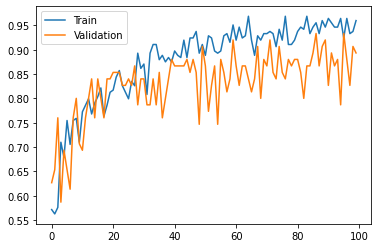

In [ ]:
history = pd.DataFrame({"Train":TRAINING_acc,"Validation":VALIDATION_acc})
history.plot()

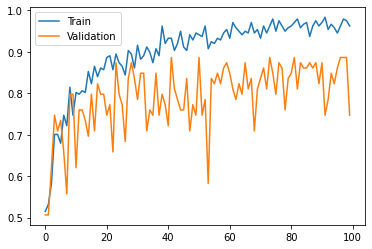

In [22]:
history = pd.DataFrame({"Train":TRAINING_acc,"Validation":VALIDATION_acc})
history.plot()

In [23]:
!ls

checkpoint_densenet161_1_0.50633.ph   checkpoint_densenet161_42_0.88608.ph
checkpoint_densenet161_18_0.82278.ph  checkpoint_densenet161_9_0.79747.ph
checkpoint_densenet161_24_0.87342.ph  OpticDiscs
checkpoint_densenet161_3_0.62025.ph   test_data.csv
checkpoint_densenet161_4_0.74684.ph


In [ ]:
torch.save(model,"checkpointDENSENET.ph")

In [ ]:
for c in y:
  print(c)

1


## Evaluation

In [ ]:
model = torch.load('checkpoint_densenet161_15_0.89333.ph')

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
predicted = []
true_values = []
all_predicted = []
all_true = []
for point in range(len(X_test)//batch_size):
    with torch.no_grad():

        X = X_test.iloc[point*batch_size:(point+1)*batch_size]
        y = y_test.iloc[point*batch_size:(point+1)*batch_size]

        true_values.append(y.values)
        # Load images
        try:
            images = [Image.open(File) for File in X]
        except:
            continue
        # Load y_true
        y_true = torch.LongTensor([c for c in y]).to(device)
        
        # Convert images to tensor
        x_batch = torch.FloatTensor().to(device)
        for image in images:
            P = composed(image).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))

        
        outputs = model(x_batch)
        loss = criterion(outputs, y_true)
        all_predicted.append(outputs.cpu().detach().numpy()[0][1])
        all_true.append(y_true.cpu().detach().numpy()[0])
        
        _, preds = torch.max(outputs, 1)
        predicted.append(preds)

In [ ]:
true_values = np.array(true_values).reshape(-1)
dummy = torch.FloatTensor().to(device)
for tensor in predicted:
    dummy = torch.cat((dummy,tensor))
predicted = dummy.view(-1).cpu().numpy()

In [ ]:
confusion_matrix(true_values, predicted)

array([[33,  4],
       [ 5, 33]])

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

ns_fpr, ns_tpr, _ = roc_curve(all_true, all_predicted)
plt.plot(ns_fpr,ns_tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
print(roc_auc_score(all_true, all_predicted))

0.88